In [1]:
import numpy as np
import laserhockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
import time
from utility import transform_obs
import matplotlib.pyplot as plt
# %matplotlib inline
from IPython import display

# Informatoin about Hockey ENV

### Observation Space
 0  x pos player one
 
 1  y pos player one

 2  angle player one

 3  x vel player one

 4  y vel player one

 5  angular vel player one

 6  x player two

 7  y player two

 8  angle player two

 9 y vel player two

 10 y vel player two

 11 angular vel player two

 12 x pos puck

 13 y pos puck


 14 x vel puck

 15 y vel puck

 Keep Puck Mode

 16 time left player has puck
 
 17 time left other player has puck

### There is a Mode where one can keep the puck as long as one wants and there is the "Keep Puck Mode" where you have only a certain time. The later ist the default mode.

### Action Space

0 linear force in x-direction

1 linear force in y-direction 

2 torque

Keep Puck Mode

3 shoot puck


### Human Opponent
If you play with the arrow keys, only one action is possible at a time with a maximum value input. (see https://github.com/martius-lab/laser-hockey-env/blob/master/laserhockey/hockey_env.py line 759)

Maybe it is better to allow combinations of actions and vaiable strength -> continuous agent

But maybe not, since it is harder to optimze

In [2]:
np.set_printoptions(suppress=True)

In [3]:
reload(h_env)

/home/lenny/anaconda3/envs/rml/lib/python3.9/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment Hockey-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/home/lenny/anaconda3/envs/rml/lib/python3.9/site-packages/gymnasium/envs/registration.py:693: UserWarning: WARN: Overriding environment Hockey-One-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


<module 'laserhockey.hockey_env' from '/home/lenny/anaconda3/envs/rml/lib/python3.9/site-packages/laserhockey/hockey_env.py'>

# Server Game Play

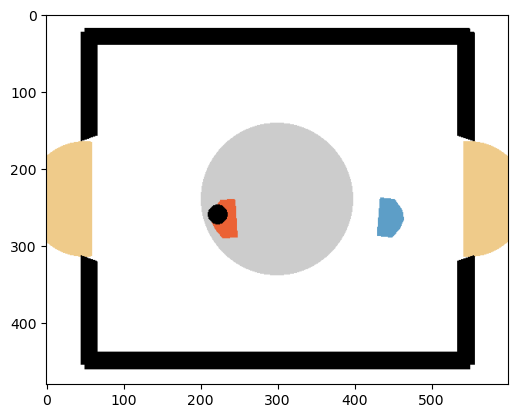

In [4]:
env = h_env.HockeyEnv()
player1 = h_env.BasicOpponent()
player2 = h_env.BasicOpponent()
obs_buffer = []
reward_buffer=[]
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()
img = plt.imshow(env.render(mode='rgb_array'))
for k in range(100):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    a1 = player1.act(obs)
    a2 = player2.act(obs_agent2)
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_buffer.append(obs)
    reward_buffer.append(r)
    obs_agent2 = env.obs_agent_two()
    if d: env.reset()
obs_buffer = np.asarray(obs_buffer)
reward_buffer = np.asarray(reward_buffer)
env.close()


# Normal Game Play

In [4]:
env = h_env.HockeyEnv()
print(env.observation_space)
print(env.action_space)

Box(-inf, inf, (18,), float32)
Box(-1.0, 1.0, (8,), float32)


have a look at the initialization condition: alternating who starts and are random in puck position

In [5]:
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()
_ = env.render()

: 

: 

In [10]:
obs

array([-3.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  3.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.74902296, -0.30289364,  0.        ,
        0.        ,  0.        ,  0.        ])

In [9]:
obs_agent2.shape

(18,)

one episode with random agents

In [24]:
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()

min = np.array([0]*18)
max = np.array([0]*18)

for _ in range(60000):
    env.render(mode="human")
    a1 = np.random.uniform(-1,1,4)
    a2 = np.random.uniform(-1,1,4)  
    obs, r, d, t, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    for i in range(18):
        if obs[i] > max[i]:
            max[i] = obs[i]
        if obs[i] < min[i]:
            min[i] = obs[i]
        if obs_agent2[i] > max[i]:
            max[i] = obs_agent2[i]
        if obs_agent2[i] < min[i]:
            min[i] = obs_agent2[i]
    # if d: break
    if _ % 1000 == 0:
        print(_)
        print(max)
        print(min)


0
[0 0 0 0 0 0 3 0 0 0 0 0 1 0 0 0 0 0]
[-3  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0]
1000
[ 0  2  1  7  8 10  3  1  1  7  6 10 32 74 56 27 15 15]
[ -3  -1  -1  -7  -6 -11   0  -2  -1  -7  -8 -11 -32 -74 -56 -27   0   0]
2000
[  0   2   1   7   8  11   3   2   1   7   7  11 102 258  56  27  15  15]
[  -3   -2   -1   -7   -7  -11    0   -2   -1   -7   -8  -11 -102 -258
  -56  -27    0    0]
3000
[  0   2   1  10   8  12   3   2   1   7   7  12 128 325  56  27  15  15]
[  -3   -2   -1   -7   -7  -11    0   -2   -1  -10   -8  -11 -128 -325
  -56  -27    0    0]


KeyboardInterrupt: 

Without rendering, it runs much faster

"info" dict contains useful proxy rewards and winning information

In [14]:
max = np.array([0]*18)
max

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Winner == 0: draw

Winner == 1: you (left player)

Winner == -1: opponent wins (right player)

In [7]:
env.close()

# Train Shooting

In [15]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_SHOOTING)
# env = h_env.HockeyEnv()

KeyboardInterrupt: 

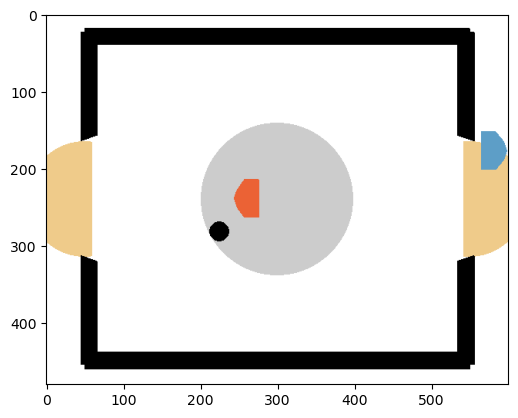

In [16]:
o, info = env.reset()
# _ = env.render()

img = plt.imshow(env.render(mode='rgb_array'))
for _ in range(5000):
    # env.render()
    env.reset()
    for _ in range(60):
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        a1 = [1,0,0,1] # np.random.uniform(-1,1,4)
        a2 = [0,0.,0,0] 
        obs, r, d, _ , info = env.step(np.hstack([a1,a2]))    
        obs_agent2 = env.obs_agent_two()
        if d: break

In [26]:
env.close()

# Train DEFENDING

In [5]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_DEFENSE)

KeyboardInterrupt: 

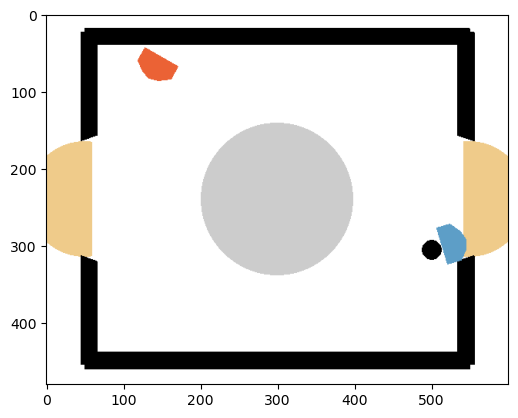

In [7]:
o, info = env.reset()
# _ = env.render()


img = plt.imshow(env.render(mode='rgb_array'))
for i in range(600):
    ob, info = env.reset()
    for _ in range(60):
        #env.render()
        img.set_data(env.render(mode='rgb_array'))
        display.display(plt.gcf())
        display.clear_output(wait=True)
        a1 = [.1,1,1,1] # np.random.uniform(-1,1,3)
        a2 = [0,0.,0,0] 
        obs, r, d,_, info = env.step(np.hstack([a1,a2]))
        obs_agent2 = env.obs_agent_two()
        if d: break

In [29]:
env.close()

# Using discrete actions

In [8]:
import random

In [9]:
env = h_env.HockeyEnv(mode=h_env.HockeyEnv.TRAIN_SHOOTING)

In [16]:
env.reset()
for _ in range(200):
    env.render()
    print(random.randint(0,7))
    a1_discrete = random.randint(0,7)
    a1 = env.discrete_to_continous_action(a1_discrete)
    print(a1)
    a2 = [0,0.,0,0 ] 
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    if d: break

0
a1 [0, 0, -1, False]
[0, 0, 0, True]
6
a1 [0, 0, 0, True]
[0, -1, 0, False]
2
a1 [0, -1, 0, False]
[-1, 0, 0, False]
4
a1 [-1, 0, 0, False]
[0, 0, 0, False]
7
a1 [0, 0, 0, False]
[1, 0, 0, False]
6
a1 [1, 0, 0, False]
[0, -1, 0, False]
6
a1 [0, -1, 0, False]
[-1, 0, 0, False]
0
a1 [-1, 0, 0, False]
[0, 0, 0, True]
2
a1 [0, 0, 0, True]
[0, 0, 1, False]
7
a1 [0, 0, 1, False]
[0, 1, 0, False]
7
a1 [0, 1, 0, False]
[1, 0, 0, False]
4
a1 [1, 0, 0, False]
[-1, 0, 0, False]
2
a1 [-1, 0, 0, False]
[0, -1, 0, False]
5
a1 [0, -1, 0, False]
[0, 0, -1, False]
6
a1 [0, 0, -1, False]
[0, 1, 0, False]
3
a1 [0, 1, 0, False]
[1, 0, 0, False]
1
a1 [1, 0, 0, False]
[0, 0, 0, True]
7
a1 [0, 0, 0, True]
[-1, 0, 0, False]
5
a1 [-1, 0, 0, False]
[0, 0, 1, False]
7
a1 [0, 0, 1, False]
[0, 0, 1, False]
7
a1 [0, 0, 1, False]
[1, 0, 0, False]
1
a1 [1, 0, 0, False]
[-1, 0, 0, False]
5
a1 [-1, 0, 0, False]
[-1, 0, 0, False]
2
a1 [-1, 0, 0, False]
[0, 1, 0, False]
1
a1 [0, 1, 0, False]
[0, 0, -1, False]
0
a1 [0, 

In [ ]:
env.close()

# Hand-crafted Opponent

In [2]:
env = h_env.HockeyEnv()

In [4]:
o, info = env.reset()
# _ = env.render()
player1 = h_env.BasicOpponent()
player2 = h_env.BasicOpponent()

In [13]:

min = np.array([0.]*18)
max = np.array([0.]*18)
min_n = np.array([0.]*18)
max_n = np.array([0.]*18)
obs_buffer = []
reward_buffer=[]
obs, info = env.reset()
obs_agent2 = env.obs_agent_two()
for k in range(80000):
    if k < 40000:
    # env.render()
        a1 = player1.act(obs)
        a2 = player2.act(obs_agent2)
    else:
        a1 = np.random.uniform(-1,1,4)
        a2 = np.random.uniform(-1,1,4)  
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_buffer.append(obs)
    reward_buffer.append(r)
    obs_agent2 = env.obs_agent_two()
    if d: env.reset()
    for i in range(18):
        if transform_obs(obs)[i] > max[i]:
            max[i] = transform_obs(obs)[i]
            max_n[i] = obs[i]
        if transform_obs(obs)[i] < min[i]:
            min[i] = transform_obs(obs)[i]
            min_n[i] = obs[i]
    # if d: break
    if k % 100 == 0:
        print('(',k,')')
        print("max trans : \n",np.round(max,2))
        print("max       : \n",np.round(max_n,2))
        print("min trans : \n",np.round(min,2))
        print("min       : \n",np.round(min_n,2))
obs_buffer = np.asarray(obs_buffer)
reward_buffer = np.asarray(reward_buffer)

( 0 )
max trans : 
 [0.   0.   0.   0.   0.   0.   1.5  0.   0.01 0.02 0.   0.01 0.   0.
 0.   0.   0.   0.  ]
max       : 
 [0.   0.   0.   0.   0.   0.   3.01 0.   0.01 0.47 0.   0.54 0.   0.
 0.   0.   0.   0.  ]
min trans : 
 [-0.5  -0.   -0.   -0.02 -0.01 -0.01  0.   -0.    0.    0.   -0.01  0.
 -0.15 -0.15  0.    0.   -0.5  -0.5 ]
min       : 
 [-3.01 -0.   -0.01 -0.47 -0.17 -0.37  0.   -0.    0.    0.   -0.17  0.
 -1.19 -0.92  0.    0.    0.    0.  ]
( 100 )
max trans : 
 [0.38 0.   0.06 0.52 0.07 0.09 1.65 0.   0.06 0.52 0.02 0.04 0.13 0.15
 0.49 0.12 0.5  0.5 ]
max       : 
 [-3.700e-01  1.000e-02  1.300e-01  1.042e+01  1.350e+00  3.720e+00
  3.440e+00  0.000e+00  1.200e-01  1.050e+01  4.900e-01  1.590e+00
  1.030e+00  9.200e-01  5.852e+01  1.444e+01  1.500e+01  1.500e+01]
min trans : 
 [-0.64 -0.17 -0.14 -0.37 -0.06 -0.03  0.   -0.16 -0.19 -0.53 -0.06 -0.1
 -0.56 -0.16 -0.42 -0.05 -0.5  -0.5 ]
min       : 
 [ -3.43  -0.67  -0.28  -7.42  -1.16  -1.38   0.    -0.66  -0.38 -10.5

In [17]:
for i in range(18):
    print(np.round(min_n,2)[i], " , ",np.round(max_n,2)[i])

-3.67  ,  -0.33
-2.98  ,  3.03
-1.24  ,  1.24
-10.83  ,  10.82
-8.28  ,  8.38
-13.41  ,  12.08
0.0  ,  3.67
-3.0  ,  2.96
-1.26  ,  1.27
-10.72  ,  10.78
-8.33  ,  10.01
-15.24  ,  13.54
-4.81  ,  4.81
-3.12  ,  3.12
-59.03  ,  62.49
-54.5  ,  51.95
0.0  ,  15.0
0.0  ,  15.0


In [62]:
np.std(obs_buffer,axis=0)

array([ 1.20937969,  0.56740473,  0.65614896,  4.57029534,  3.77917972,
        3.27725322,  0.57985812,  0.37711888,  0.14472327,  3.50542317,
        1.34537328,  0.7138057 ,  1.7929023 ,  1.2691233 , 16.63316537,
        9.28411951,  4.01716318,  3.55420877])

If you want to use a fixed observation scaling, this might be a reasonable choice

In [63]:
scaling = [ 1.0,  1.0 , 0.5, 4.0, 4.0, 4.0,  
            1.0,  1.0,  0.5, 4.0, 4.0, 4.0,  
            2.0, 2.0, 10.0, 10.0, 4,0 ,4,0]

In [65]:
import pylab as plt

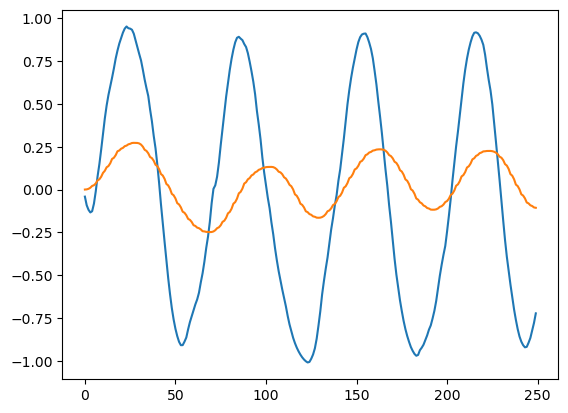

In [66]:
plt.plot(obs_buffer[:,2])
plt.plot(obs_buffer[:,8])

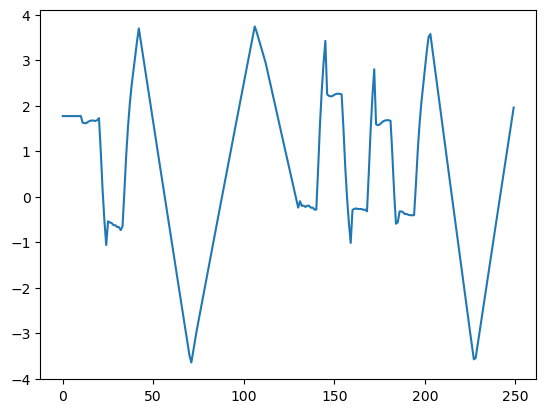

In [67]:
plt.plot(obs_buffer[:,12])

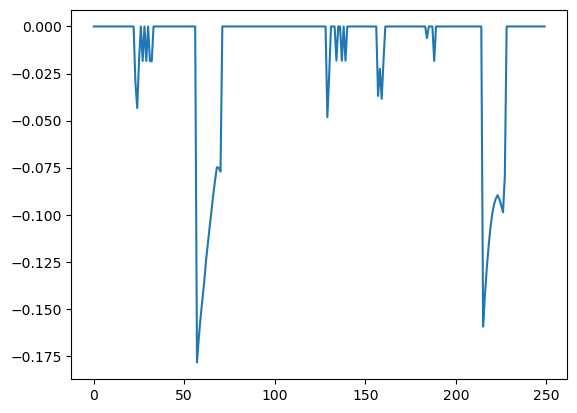

In [68]:
plt.plot(reward_buffer[:])

In [69]:
np.sum(reward_buffer)

-3.450028876848684

In [ ]:
env.close()

# Human Opponent

In [1]:
import numpy as np
import laserhockey.hockey_env as h_env
import gymnasium as gym
from importlib import reload
import time
env = h_env.HockeyEnv()

In [2]:
player1 = h_env.HumanOpponent(env=env, player=1)
player2 = h_env.BasicOpponent()


: 

: 

In [ ]:
player1 = h_env.BasicOpponent()
player2 = h_env.HumanOpponent(env=env, player=2)


Human Controls:
 left:			left arrow key left
 right:			arrow key right
 up:			arrow key up
 down:			arrow key down
 tilt clockwise:	w
 tilt anti-clockwise:	s
 shoot :	space


: 

In [ ]:
obs, info = env.reset()

min = np.array([0]*18)
max = np.array([0]*18)
min2 = np.array([0]*18)
max2 = np.array([0]*18)
env.render()
time.sleep(1)
obs_agent2 = env.obs_agent_two()
for j in range(100000):
    time.sleep(0.2)
    env.render()
    a1 = player1.act(obs) 
    a2 = player2.act(obs_agent2)
    obs, r, d, _, info = env.step(np.hstack([a1,a2]))    
    obs_agent2 = env.obs_agent_two()
    for i in range(18):
        if obs[i] > max[i]:
            max[i] = obs[i]
        if obs[i] < min[i]:
            min[i] = obs[i]
    if d: env.reset()
    if j % 100 == 0:
        print(_)
        print(max)
        print(min)

In [ ]:
env.close()

In [ ]:
[ 0  1  0 10  3  1  3  2  1 10 10 19 30  3 18 14  0 15]
[ -3   0   0  -9  -2  -1   0  -2  -1 -10 -10 -17  -3  -6 -52 -28   0   0]
[ 0  2  1 10 10 19  3  0  0  9  2  1  3  6 52 28 15  0]
[ -3  -2  -1 -10 -10 -17   0  -1   0 -10  -3  -1 -30  -3 -18 -14   0   0]

In [18]:
max

array([  0,   0,   0,   8,   1,   1,   3,   2,   1,  10,  10,  18, 136,
        20,  59,  18,  15,  15])

In [ ]:
[ 0  2  0 10 10  1  3  2  0  9 10  1  1  0  0  0  0  0]
[ -3  -2   0  -9 -10  -1   0  -2   0 -10 -10  -1  -1   0   0   0   0   0]

In [19]:
# max = [  0   2   1  10  10  17   3   2   1  10  10  17 255   9  60  14  15  15]
# min = [  -3   -2   -1  -10  -10  -16    0   -2   -1  -10  -10  -16 -255   -9 -60  -14    0    0]
names = ["x pos player one",
'y pos player one',
'angle player one',
'x vel player one',
'y vel player one',
'angular vel player one',
'x player two',
'y player two',
'angle player two',
'y vel player two',
'y vel player two',
'angular vel player two',
'x pos puck',
'y pos puck',
'x vel puck',
'y vel puck',
'time left player has puck',
'time left other player has puck']
for i in range(18):
    # print(names[i]," : ",min[i]," - ",max[i])
    print(names[i]," : ",min2[i]," - ",max2[i])

x pos player one  :  -3  -  0
y pos player one  :  -2  -  2
angle player one  :  -1  -  1
x vel player one  :  -10  -  10
y vel player one  :  -10  -  10
angular vel player one  :  -19  -  18
x player two  :  0  -  3
y player two  :  0  -  1
angle player two  :  0  -  0
y vel player two  :  -8  -  6
y vel player two  :  -1  -  2
angular vel player two  :  -1  -  1
x pos puck  :  -136  -  3
y pos puck  :  -20  -  3
x vel puck  :  -59  -  52
y vel puck  :  -18  -  10
time left player has puck  :  0  -  15
time left other player has puck  :  0  -  15


In [30]:

for i in range(18):
    # print(names[i]," : ",min[i]," - ",max[i])
    print(names[i]," : ",min[i]," - ",max[i])

x pos player one  :  -3  -  0
y pos player one  :  -2  -  1
angle player one  :  -1  -  1
x vel player one  :  -10  -  10
y vel player one  :  -10  -  10
angular vel player one  :  -14  -  12
x player two  :  0  -  3
y player two  :  0  -  1
angle player two  :  0  -  0
y vel player two  :  -10  -  10
y vel player two  :  -2  -  3
angular vel player two  :  -1  -  1
x pos puck  :  -4  -  3
y pos puck  :  -3  -  3
x vel puck  :  -55  -  60
y vel puck  :  -52  -  23
time left player has puck  :  0  -  15
time left other player has puck  :  0  -  15


In [ ]:
max speed 10
max Angle pi/3
maxpuckspeed 25
